In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape
from tensorflow.keras.utils import to_categorical
from numpy import array as nar, ndarray as ndar

# import matplotlib
# import matplotlib.pylab as plt

from sklearn.datasets import make_regression
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split

Define our class for Ordinal Regression

In [2]:
class OrdinalOutput(keras.layers.Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        self.t0 = tf.constant(-np.inf, shape=(1, 1))
        self.tK = tf.constant(np.inf, shape=(1, 1))
        super(OrdinalOutput, self).__init__(**kwargs)

    def build(self, input_shape):
        assert input_shape[-1] == 1 and len(input_shape) <= 2
        # TODO: handle input with extra dimensions and
        # different regression axis
        # e.g. sequence of time-major or not
        self.thresholds = self.add_weight(
            name='thresholds',
            shape=(1, self.output_dim - 1),
            initializer=self.sorted_initializer('glorot_uniform'),
            trainable=True)
        # 1. Overwritting `self.thresholds` attribute causes
        # TF not to maintain the added weight.
        # 2. Calling tf.concat here is eager by default
        # and causes the result to be treated as constant.
        # (found by looking at Tensor Board graph)
        # Moved to `call`.
        super(OrdinalOutput, self).build(input_shape)

    def call(self, x):
        upper = tf.concat([self.thresholds, self.tK],  axis=-1)
        lower = tf.concat([self.t0, self.thresholds],  axis=-1)
        output = tf.sigmoid(upper - x) - tf.sigmoid(lower - x)
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def sorted_initializer(self, initializer):
        # Returns a function that returns a sorted
        # initialization based on an initializer string
        initializer = keras.initializers.get(initializer)

        def sorter(shape, dtype=None):
            # Returns a sorted initialization
            return tf.sort(initializer(shape, dtype))
        return sorter

Generate example data

In [4]:
x, y = make_regression(
    n_samples=10000,
    n_features=20,
    n_informative=15)
f"{y.mean()},{y.std()}"

'1.8382379994527567,243.15147715095588'

In [5]:
qt = QuantileTransformer()
t = qt.fit_transform(y.reshape(-1, 1))[:,0]
t = np.floor(t * 4) # Encode to 4 uniformly distributed ranks
# few data were put into 5th category
# discard since this is only a demo
t = to_categorical(t)[:,:4]
t.mean(axis=0)
x_train, x_val, y_train, y_val = train_test_split(x, t)

array([0.25  , 0.2499, 0.2503, 0.2497], dtype=float32)

Build the model

In [7]:
model = keras.Sequential()
model.add(Dense(units=32, activation='relu', input_dim=20))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='linear'))
model.add(OrdinalOutput(output_dim=4))

Examine the ordinal thresholds

In [8]:
model.layers[-1].get_weights()

[array([[-0.34376454, -0.2772141 ,  0.55148065]], dtype=float32)]

And compare after training

In [13]:
model.layers[-1].get_weights()

[array([[-1.3191272 ,  0.26595005,  2.3397858 ]], dtype=float32)]

If you wish to inspect the graph from Tensor Board, run this to clear previous models from the graph.

In [66]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

Just a moment

In [10]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                672       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
_________________________________________________________________
ordinal_output (OrdinalOutpu (None, 4)                 3         
Total params: 1,764
Trainable params: 1,764
Non-trainable params: 0
_________________________________________________________________


Training.

In [12]:
history = model.fit(
    x_train, y_train[:,:4],
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y_val[:,:4])
#     callbacks=[keras.callbacks.TensorBoard(log_dir=r'..\\e-tblogs')]
)

Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 2s 209us/sample - loss: 1.3909 - accuracy: 0.4631 - val_loss: 1.1412 - val_accuracy: 0.4992
Epoch 2/10
7500/7500 [==============================] - 1s 84us/sample - loss: 1.0525 - accuracy: 0.4999 - val_loss: 0.9820 - val_accuracy: 0.4992
Epoch 3/10
7500/7500 [==============================] - 1s 84us/sample - loss: 0.9259 - accuracy: 0.5003 - val_loss: 0.8806 - val_accuracy: 0.5060
Epoch 4/10
7500/7500 [==============================] - 1s 87us/sample - loss: 0.8357 - accuracy: 0.5355 - val_loss: 0.8024 - val_accuracy: 0.5572
Epoch 5/10
7500/7500 [==============================] - 1s 86us/sample - loss: 0.7630 - accuracy: 0.5859 - val_loss: 0.7338 - val_accuracy: 0.6072
Epoch 6/10
7500/7500 [==============================] - 1s 83us/sample - loss: 0.7016 - accuracy: 0.6261 - val_loss: 0.6787 - val_accuracy: 0.6356
Epoch 7/10
7500/7500 [==============================] - 1s 83us/sampl

This cell was left from previous testing code. Do **not** run it since `t` or `y` now either exists not or has changed meaning. It was kept because the figure is some how useful.

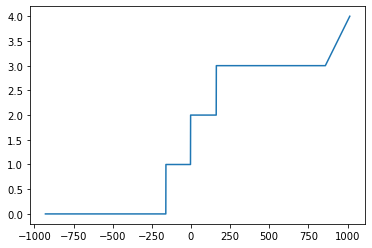

In [37]:
ind = np.argsort(y)
plt.plot(y[ind], t[ind])